In [1]:
import pandas as pd
import os
import numpy as np
import time
import tensorflow.keras.initializers
import statistics
import tensorflow.keras as keras
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, InputLayer
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import ShuffleSplit
from tensorflow.keras.layers import ReLU
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
# Data directly taken from PDF
Ebins = np.array([1.00E-03,2.15E-03,4.64E-03,1.00E-02,2.15E-02,4.64E-02,1.00E-01,2.15E-01,4.64E-01,1.00E+00,2.15E+00,4.64E+00,1.00E+01,2.15E+01,4.64E+01,1.00E+02,2.15E+02,4.64E+02,1.00E+03,2.15E+03,4.64E+03,1.00E+04,1.25E+04,1.58E+04,1.99E+04,2.51E+04,3.16E+04,3.98E+04,5.01E+04,6.30E+04,7.94E+04,1.00E+05,1.25E+05,1.58E+05,1.99E+05,2.51E+05,3.16E+05,3.98E+05,5.01E+05,6.30E+05,7.94E+05,1.00E+06,1.25E+06,1.58E+06,1.99E+06,2.51E+06,3.16E+06,3.98E+06,5.01E+06,6.30E+06,7.94E+06,1.00E+07,1.58E+07])

cm = np.array([
[6.11E+00,5.60E+00,4.80E+00,3.89E+00,3.03E+00,2.27E+00,1.64E+00,1.17E+00,8.20E-01,5.72E-01,3.94E-01,2.73E-01,1.90E-01,1.28E-01,8.88E-02,6.02E-02,4.05E-02,2.79E-02,1.91E-02,1.27E-02,9.01E-03,6.86E-03,6.24E-03,5.62E-03,4.99E-03,4.37E-03,3.83E-03,3.36E-03,2.90E-03,2.43E-03,1.97E-03,1.64E-03,1.47E-03,1.31E-03,1.15E-03,9.96E-04,8.95E-04,8.61E-04,8.28E-04,7.94E-04,7.60E-04,7.22E-04,6.79E-04,6.37E-04,5.94E-04,5.51E-04,4.94E-04,4.19E-04,3.44E-04,2.70E-04,1.97E-04,1.39E-04,1.00E-04],
[7.36E-01,8.08E-01,9.34E-01,1.12E+00,1.36E+00,1.72E+00,2.11E+00,2.38E+00,2.47E+00,2.46E+00,2.37E+00,2.24E+00,2.04E+00,1.85E+00,1.65E+00,1.47E+00,1.30E+00,1.14E+00,1.01E+00,8.83E-01,7.64E-01,6.98E-01,6.69E-01,6.39E-01,6.09E-01,5.81E-01,5.54E-01,5.26E-01,4.99E-01,4.71E-01,4.41E-01,4.09E-01,3.77E-01,3.45E-01,3.13E-01,2.81E-01,2.49E-01,2.17E-01,1.87E-01,1.59E-01,1.34E-01,1.11E-01,9.38E-02,7.58E-02,5.80E-02,4.42E-02,3.52E-02,2.63E-02,1.95E-02,1.52E-02,1.10E-02,7.43E-03,4.65E-03],
[5.98E-01,6.57E-01,7.58E-01,9.00E-01,1.08E+00,1.42E+00,1.89E+00,2.27E+00,2.51E+00,2.65E+00,2.69E+00,2.67E+00,2.58E+00,2.45E+00,2.29E+00,2.14E+00,1.98E+00,1.83E+00,1.67E+00,1.53E+00,1.39E+00,1.31E+00,1.27E+00,1.23E+00,1.20E+00,1.16E+00,1.13E+00,1.09E+00,1.05E+00,1.02E+00,9.77E-01,9.33E-01,8.87E-01,8.35E-01,7.78E-01,7.19E-01,6.57E-01,5.94E-01,5.27E-01,4.61E-01,3.96E-01,3.39E-01,2.90E-01,2.42E-01,1.94E-01,1.54E-01,1.24E-01,9.54E-02,7.21E-02,5.66E-02,4.15E-02,2.81E-02,1.77E-02],
[5.01E-01,5.50E-01,6.34E-01,7.50E-01,9.18E-01,1.22E+00,1.62E+00,2.00E+00,2.31E+00,2.52E+00,2.66E+00,2.75E+00,2.75E+00,2.71E+00,2.63E+00,2.53E+00,2.41E+00,2.30E+00,2.18E+00,2.04E+00,1.92E+00,1.84E+00,1.81E+00,1.78E+00,1.74E+00,1.71E+00,1.67E+00,1.64E+00,1.61E+00,1.57E+00,1.53E+00,1.49E+00,1.44E+00,1.38E+00,1.32E+00,1.25E+00,1.17E+00,1.09E+00,9.97E-01,8.96E-01,7.96E-01,6.97E-01,6.02E-01,5.13E-01,4.24E-01,3.47E-01,2.85E-01,2.24E-01,1.77E-01,1.49E-01,1.21E-01,7.95E-02,4.26E-02],
[4.15E-01,4.55E-01,5.24E-01,6.18E-01,7.61E-01,1.01E+00,1.36E+00,1.72E+00,2.04E+00,2.27E+00,2.45E+00,2.58E+00,2.64E+00,2.67E+00,2.66E+00,2.63E+00,2.58E+00,2.51E+00,2.43E+00,2.35E+00,2.26E+00,2.21E+00,2.18E+00,2.15E+00,2.13E+00,2.10E+00,2.08E+00,2.06E+00,2.04E+00,2.02E+00,1.99E+00,1.95E+00,1.92E+00,1.88E+00,1.83E+00,1.77E+00,1.70E+00,1.61E+00,1.51E+00,1.38E+00,1.26E+00,1.13E+00,1.00E+00,8.67E-01,7.33E-01,6.13E-01,5.10E-01,4.08E-01,3.30E-01,2.80E-01,2.30E-01,1.55E-01,8.39E-02],
[3.43E-01,3.75E-01,4.31E-01,5.11E-01,6.31E-01,8.34E-01,1.12E+00,1.43E+00,1.72E+00,1.95E+00,2.13E+00,2.29E+00,2.39E+00,2.46E+00,2.50E+00,2.51E+00,2.52E+00,2.52E+00,2.47E+00,2.44E+00,2.39E+00,2.36E+00,2.35E+00,2.34E+00,2.33E+00,2.32E+00,2.31E+00,2.31E+00,2.30E+00,2.29E+00,2.28E+00,2.27E+00,2.26E+00,2.24E+00,2.22E+00,2.19E+00,2.13E+00,2.07E+00,1.97E+00,1.86E+00,1.73E+00,1.59E+00,1.42E+00,1.25E+00,1.08E+00,9.20E-01,7.60E-01,6.27E-01,5.14E-01,4.09E-01,3.03E-01,2.25E-01,1.40E-01],
[2.80E-01,3.07E-01,3.53E-01,4.23E-01,5.13E-01,6.91E-01,9.32E-01,1.18E+00,1.41E+00,1.62E+00,1.81E+00,1.95E+00,2.07E+00,2.18E+00,2.24E+00,2.29E+00,2.32E+00,2.34E+00,2.36E+00,2.36E+00,2.33E+00,2.33E+00,2.33E+00,2.33E+00,2.34E+00,2.34E+00,2.35E+00,2.37E+00,2.38E+00,2.39E+00,2.41E+00,2.43E+00,2.44E+00,2.46E+00,2.47E+00,2.47E+00,2.44E+00,2.40E+00,2.33E+00,2.23E+00,2.10E+00,1.98E+00,1.82E+00,1.63E+00,1.45E+00,1.26E+00,1.07E+00,8.88E-01,7.36E-01,6.29E-01,5.22E-01,3.61E-01,2.04E-01],
[1.85E-01,2.05E-01,2.34E-01,2.79E-01,3.42E-01,4.57E-01,6.16E-01,7.74E-01,9.38E-01,1.08E+00,1.22E+00,1.34E+00,1.44E+00,1.52E+00,1.61E+00,1.69E+00,1.74E+00,1.80E+00,1.87E+00,1.90E+00,1.92E+00,1.96E+00,1.98E+00,2.00E+00,2.02E+00,2.05E+00,2.08E+00,2.12E+00,2.16E+00,2.20E+00,2.25E+00,2.31E+00,2.37E+00,2.43E+00,2.50E+00,2.57E+00,2.62E+00,2.66E+00,2.68E+00,2.67E+00,2.61E+00,2.53E+00,2.42E+00,2.25E+00,2.06E+00,1.82E+00,1.57E+00,1.36E+00,1.16E+00,9.63E-01,7.98E-01,5.95E-01,3.53E-01],
[1.18E-01,1.30E-01,1.52E-01,1.79E-01,2.13E-01,2.91E-01,3.95E-01,5.07E-01,6.09E-01,7.04E-01,7.92E-01,8.66E-01,9.43E-01,1.02E+00,1.08E+00,1.14E+00,1.20E+00,1.25E+00,1.31E+00,1.37E+00,1.42E+00,1.46E+00,1.48E+00,1.50E+00,1.53E+00,1.55E+00,1.58E+00,1.62E+00,1.67E+00,1.73E+00,1.80E+00,1.87E+00,1.95E+00,2.05E+00,2.15E+00,2.27E+00,2.41E+00,2.52E+00,2.59E+00,2.65E+00,2.70E+00,2.71E+00,2.67E+00,2.58E+00,2.44E+00,2.25E+00,2.02E+00,1.78E+00,1.55E+00,1.31E+00,1.07E+00,8.07E-01,5.25E-01],
[7.19E-02,8.04E-02,9.38E-02,1.13E-01,1.40E-01,1.84E-01,2.52E-01,3.21E-01,3.84E-01,4.42E-01,5.04E-01,5.58E-01,6.06E-01,6.49E-01,6.77E-01,7.23E-01,7.85E-01,8.28E-01,8.73E-01,9.13E-01,9.47E-01,9.90E-01,1.01E+00,1.04E+00,1.06E+00,1.08E+00,1.12E+00,1.16E+00,1.21E+00,1.25E+00,1.32E+00,1.38E+00,1.46E+00,1.56E+00,1.68E+00,1.80E+00,1.95E+00,2.08E+00,2.22E+00,2.35E+00,2.47E+00,2.57E+00,2.65E+00,2.64E+00,2.54E+00,2.38E+00,2.16E+00,2.01E+00,1.87E+00,1.62E+00,1.31E+00,1.02E+00,6.80E-01],
[3.63E-02,4.04E-02,4.84E-02,5.66E-02,6.52E-02,8.84E-02,1.21E-01,1.55E-01,1.90E-01,2.19E-01,2.43E-01,2.75E-01,2.99E-01,3.16E-01,3.39E-01,3.64E-01,3.90E-01,4.13E-01,4.36E-01,4.68E-01,5.00E-01,5.23E-01,5.34E-01,5.45E-01,5.56E-01,5.70E-01,5.91E-01,6.15E-01,6.37E-01,6.64E-01,7.03E-01,7.52E-01,8.14E-01,8.93E-01,9.84E-01,1.08E+00,1.21E+00,1.35E+00,1.52E+00,1.69E+00,1.88E+00,2.06E+00,2.22E+00,2.35E+00,2.41E+00,2.36E+00,2.22E+00,2.13E+00,2.03E+00,1.80E+00,1.56E+00,1.24E+00,8.69E-01],
[2.72E-02,3.05E-02,3.71E-02,4.49E-02,5.41E-02,6.96E-02,9.36E-02,1.26E-01,1.48E-01,1.70E-01,1.92E-01,2.18E-01,2.33E-01,2.37E-01,2.65E-01,2.89E-01,3.08E-01,3.26E-01,3.46E-01,3.70E-01,3.83E-01,4.06E-01,4.22E-01,4.38E-01,4.53E-01,4.69E-01,4.83E-01,4.97E-01,5.10E-01,5.29E-01,5.61E-01,6.09E-01,6.70E-01,7.43E-01,8.24E-01,9.19E-01,1.03E+00,1.14E+00,1.29E+00,1.46E+00,1.66E+00,1.85E+00,2.02E+00,2.19E+00,2.30E+00,2.29E+00,2.18E+00,2.10E+00,2.03E+00,1.82E+00,1.60E+00,1.31E+00,9.15E-01],
[1.05E-02,1.11E-02,1.29E-02,1.55E-02,1.94E-02,2.79E-02,3.72E-02,4.61E-02,5.23E-02,5.95E-02,7.00E-02,7.80E-02,8.42E-02,8.85E-02,9.14E-02,1.01E-01,1.17E-01,1.20E-01,1.28E-01,1.34E-01,1.43E-01,1.46E-01,1.54E-01,1.62E-01,1.66E-01,1.65E-01,1.67E-01,1.73E-01,1.87E-01,2.06E-01,2.26E-01,2.40E-01,2.54E-01,2.84E-01,3.25E-01,3.79E-01,4.50E-01,5.37E-01,6.52E-01,7.77E-01,9.34E-01,1.12E+00,1.32E+00,1.51E+00,1.68E+00,1.77E+00,1.77E+00,1.88E+00,1.98E+00,1.89E+00,1.68E+00,1.43E+00,1.05E+00],
[1.65E-03,2.14E-03,2.62E-03,3.40E-03,4.49E-03,5.06E-03,6.08E-03,8.28E-03,1.04E-02,1.26E-02,1.46E-02,1.60E-02,1.70E-02,1.80E-02,2.01E-02,2.21E-02,2.39E-02,2.40E-02,2.27E-02,2.46E-02,2.65E-02,2.94E-02,3.12E-02,3.30E-02,3.48E-02,3.63E-02,3.72E-02,3.78E-02,3.84E-02,4.01E-02,4.48E-02,5.09E-02,5.71E-02,6.37E-02,7.14E-02,8.52E-02,1.06E-01,1.32E-01,1.73E-01,2.28E-01,3.12E-01,4.31E-01,5.70E-01,7.23E-01,8.93E-01,1.03E+00,1.11E+00,1.31E+00,1.55E+00,1.59E+00,1.52E+00,1.40E+00,1.09E+00],
[4.83E-04,4.94E-04,5.05E-04,6.48E-04,9.25E-04,1.11E-03,1.21E-03,1.33E-03,1.45E-03,1.63E-03,1.87E-03,2.12E-03,3.00E-03,4.46E-03,4.11E-03,3.78E-03,3.54E-03,3.66E-03,4.27E-03,4.84E-03,5.42E-03,6.01E-03,6.35E-03,6.69E-03,7.03E-03,7.31E-03,7.49E-03,7.62E-03,7.76E-03,7.97E-03,8.39E-03,9.16E-03,1.03E-02,1.20E-02,1.42E-02,1.83E-02,2.47E-02,3.10E-02,4.07E-02,5.80E-02,8.93E-02,1.39E-01,2.08E-01,3.07E-01,4.30E-01,5.79E-01,7.51E-01,9.22E-01,1.10E+00,1.22E+00,1.25E+00,1.22E+00,1.08E+00]])

# For Using Bayesian Optimization on Various Types of Data

In [312]:
def getModel(numNeurons0, numNeurons1, numNeurons2, dropout, alpha):
    
    numNeurons0 = int(numNeurons0)
    numNeurons1 = int(numNeurons1)
    numNeurons2 = int(numNeurons2)
 
    model = keras.Sequential()
    
    model.add(keras.Input(15))
    
    if numNeurons0 >= 1:
        model.add(Dropout(dropout))
        model.add(Dense(numNeurons0, activation=keras.layers.LeakyReLU(alpha=alpha)))
    if numNeurons1 >= 1:
        model.add(Dropout(dropout))
        model.add(Dense(numNeurons1, activation=keras.layers.LeakyReLU(alpha=alpha)))
    if numNeurons2 >= 1:
        model.add(Dropout(dropout))
        model.add(Dense(numNeurons2, activation=keras.layers.LeakyReLU(alpha=alpha)))
   
    model.add(Dense(53, activation='linear'))
    
    return model


def getMeanError(numNeurons0, numNeurons1, numNeurons2, dropout, lr, alpha, dataSource, retMore = False):
    
    x,y = dataSource()
    
    # Splits the data into 3 folds for bootstrapping
    SPLITS = 3
    boot = ShuffleSplit(n_splits = SPLITS, test_size=0.1, random_state=42)
    
    # Track the progress
    benchmarks = []
    epochs_needed = []
    num = 0
    
    model = None
    
    # Bootstrap the data for mean error
    for train, test in boot.split(x):
                
        # Compile model
        model = getModel(numNeurons0, numNeurons1, numNeurons2, dropout, alpha)
        model.compile(loss = "mse", optimizer = Adam(lr=lr) )
        
        # Sets up early stopping
        monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, 
                                patience=100, verbose=0,
                                mode='min', restore_best_weights=True)
        
        # Split test and train data
        xtrain = x[train]
        xtest = x[test]

        ytrain = y[train]
        ytest = y[test]
            
        # Fits to the bootstrap data
        model.fit(xtrain,ytrain,validation_data=(xtest,ytest),batch_size=32,callbacks=[monitor],verbose=0,epochs=10000)

        # Gets the epochs needed to converge
        epochs_needed.append(monitor.stopped_epoch)
        
        # Checks how well the test data was fit
        if retMore:
            xtest, ytest = loadXY()
        ypred = model(xtest)
        score = metrics.mean_squared_error(ytest, ypred)
        benchmarks.append(score)
        
    mean_benchmark = np.mean(benchmarks)
    std_benchmark = np.std(benchmarks)
    mean_epochs = np.mean(epochs_needed)
    
    if retMore:
        return mean_benchmark, std_benchmark, model
    else:
        print("Score : " , mean_benchmark , " Epochs Needed : " , mean_epochs)
        return -mean_benchmark
        

# Training NN on Mono-Energetic Data

In [314]:
# Optimizes the Neural Network using convoluted monoenergetic data, to simulate
# the monoenergetic data of the Geant4 Simulations

pbounds = { "numNeurons0" : (50, 300),
            "numNeurons1" : (50, 300),
            "numNeurons2" : (50, 300),
            "dropout"     : (0, 0.05),
            "lr"          : (0, 0.05),
            "alpha"       : (0, 0.8)}

def convolutedMonoData(numNeurons0, numNeurons1, numNeurons2, dropout, lr, alpha): 
    return getMeanError(numNeurons0, numNeurons1, numNeurons2, dropout, lr, alpha, loadRandomGaussianMonoData)

optimizer = BayesianOptimization(
    f=convolutedMonoData,
    pbounds=pbounds,
    verbose=2,
    random_state=1
)

optimizer.maximize(init_points=50, n_iter=100)

print("Best Value : " , optimizer.max)

|   iter    |  target   |   alpha   |  dropout  |    lr     | numNeu... | numNeu... | numNeu... |
-------------------------------------------------------------------------------------------------
Score :  0.0025212130290441425  Epochs Needed :  2889.3333333333335
|  1        | -0.002521 |  0.3336   |  0.03602  |  5.719e-0 |  125.6    |  86.69    |  73.08    |
Score :  0.005440003115158681  Epochs Needed :  198.0
|  2        | -0.00544  |  0.149    |  0.01728  |  0.01984  |  184.7    |  154.8    |  221.3    |
Score :  0.002123853440520211  Epochs Needed :  208.66666666666666
|  3        | -0.002124 |  0.1636   |  0.04391  |  0.001369 |  217.6    |  154.3    |  189.7    |
Score :  0.012196636563543065  Epochs Needed :  407.3333333333333
|  4        | -0.0122   |  0.1123   |  0.009905 |  0.04004  |  292.1    |  128.4    |  223.1    |
Score :  0.0019421664317269885  Epochs Needed :  160.33333333333334
|  5        | -0.001942 |  0.7011   |  0.04473  |  0.004252 |  59.76    |  92.46    |  26

Score :  0.007625536444663902  Epochs Needed :  188.0
|  37       | -0.007626 |  0.01722  |  0.0474   |  0.04136  |  53.75    |  94.05    |  133.0    |
Score :  0.002117564911167476  Epochs Needed :  315.0
|  38       | -0.002118 |  0.1048   |  0.04047  |  0.01724  |  285.0    |  195.5    |  269.7    |
Score :  0.007551026804928765  Epochs Needed :  320.3333333333333
|  39       | -0.007551 |  0.6758   |  0.04527  |  0.02299  |  186.6    |  249.7    |  121.4    |
Score :  0.009773929249348392  Epochs Needed :  325.3333333333333
|  40       | -0.009774 |  0.3922   |  0.02996  |  0.000776 |  198.4    |  158.4    |  251.8    |
Score :  0.00458371532179468  Epochs Needed :  274.0
|  41       | -0.004584 |  0.2522   |  0.04464  |  0.02889  |  96.0     |  247.0    |  203.0    |
Score :  0.003972258828444431  Epochs Needed :  342.0
|  42       | -0.003972 |  0.04313  |  0.02101  |  0.03395  |  279.7    |  50.1     |  294.2    |
Score :  0.004559857651279131  Epochs Needed :  410.3333333333333

Score :  0.0030225174638813493  Epochs Needed :  331.6666666666667
|  74       | -0.003023 |  0.1141   |  0.003727 |  0.03614  |  55.39    |  138.5    |  297.5    |
Score :  0.002660771096565559  Epochs Needed :  179.0
|  75       | -0.002661 |  0.2487   |  0.046    |  0.009652 |  208.4    |  110.0    |  50.93    |
Score :  0.010177763038348624  Epochs Needed :  167.0
|  76       | -0.01018  |  0.009971 |  0.01312  |  0.02292  |  143.6    |  108.9    |  299.5    |
Score :  0.005316618166580991  Epochs Needed :  204.33333333333334
|  77       | -0.005317 |  0.06595  |  0.01356  |  0.04316  |  50.4     |  53.2     |  120.6    |
Score :  0.003691018595325408  Epochs Needed :  187.66666666666666
|  78       | -0.003691 |  0.6219   |  0.007021 |  0.01303  |  299.9    |  53.02    |  243.1    |
Score :  0.0024882526120670327  Epochs Needed :  213.0
|  79       | -0.002488 |  0.2538   |  0.02802  |  0.009546 |  52.17    |  240.0    |  262.4    |
Score :  0.012183505744434428  Epochs Needed :  

Score :  0.003533000907552933  Epochs Needed :  160.0
|  111      | -0.003533 |  0.4154   |  0.01189  |  0.01176  |  50.57    |  175.4    |  247.4    |
Score :  0.0022183779982516854  Epochs Needed :  379.6666666666667
|  112      | -0.002218 |  0.037    |  0.04444  |  0.02933  |  294.8    |  179.4    |  299.8    |
Score :  0.007497374874251967  Epochs Needed :  158.66666666666666
|  113      | -0.007497 |  0.3526   |  0.04602  |  0.01394  |  148.9    |  61.49    |  183.4    |
Score :  0.005783509695951102  Epochs Needed :  492.6666666666667
|  114      | -0.005784 |  0.1243   |  0.003143 |  0.04849  |  165.8    |  89.52    |  228.3    |
Score :  0.0030874374617484734  Epochs Needed :  477.0
|  115      | -0.003087 |  0.5032   |  0.002027 |  0.02529  |  299.7    |  298.7    |  243.4    |
Score :  0.005279314662234041  Epochs Needed :  214.66666666666666
|  116      | -0.005279 |  0.7298   |  0.04412  |  0.008009 |  299.6    |  298.5    |  178.3    |
Score :  0.0056247678328440786  Epoc

Score :  0.0039927283968831965  Epochs Needed :  524.6666666666666
|  148      | -0.003993 |  0.3709   |  0.01522  |  0.03288  |  51.04    |  280.6    |  250.2    |
Score :  0.0017796769044016655  Epochs Needed :  178.66666666666666
|  149      | -0.00178  |  0.01423  |  0.04358  |  0.008755 |  103.8    |  296.8    |  192.0    |
Score :  0.002728810476449373  Epochs Needed :  267.3333333333333
|  150      | -0.002729 |  0.7719   |  0.02056  |  0.02377  |  166.2    |  53.06    |  143.7    |
Best Value :  {'target': -0.0010581735487193201, 'params': {'alpha': 0.03564150283580938, 'dropout': 0.0053747064553046455, 'lr': 0.011285466930392736, 'numNeurons0': 228.24724509566917, 'numNeurons1': 189.92924551353562, 'numNeurons2': 53.13899503977896}}


In [320]:
Best = optimizer.max["params"]

numNeurons0 = Best["numNeurons0"]
numNeurons1 = Best["numNeurons0"]
numNeurons2 = Best["numNeurons0"]
dropout = Best["dropout"]
lr = Best["lr"]
alpha = Best["alpha"]

# Methods for Getting Various Data

In [324]:
# Loads the real-world data from IAS tecdoc
def loadXY():

    '''
    Can't figure out how to pass non-optimiziable variable to the bayes opt
    module. Just load them from pickle everytime in evaluate_network()
    '''
    unfolding_data = pd.read_pickle("ANN_intro_James/data/unfolding_data.pkl")

    X = np.zeros((251,15))
    Y = np.zeros((251,53))
    for row in range(251):
    
        X[row,:] = unfolding_data['Detector Response'][row]
        Y[row,:] = unfolding_data['Spectrum'][row][0:53]
    
    return X,Y

# Uses the detector response matrix to generate monoenergetic data, 
# and all possible convolutions of two monoenergetic data
def loadConvolutedMonoData():
    
    # All of the neutron spectra are multiplied by fluences
    fluences = np.zeros(53)
    for i in range(53):
        temp = np.append(Ebins, [2.51E+07])
        fluences[i] = np.log(temp[i + 1]) - np.log(temp[i])
        
    x = np.zeros( (0, 15) )
    y = np.zeros( (0, 53) )
    
    # Get all mono-energetic and double-energetic data
    for i in range(53):
        for j in range(53):
            yRow = np.zeros(53)

            yRow[i] += 0.5
            yRow[j] += 0.5

            xRow = np.matmul(cm, yRow)
            yRow = yRow / fluences

            x = np.vstack( (x, xRow) )
            y = np.vstack( (y, yRow) )    
    
    return x,y

def loadRandomData():
    
    # All of the neutron spectra are multiplied by fluences
    fluences = np.zeros(53)
    for i in range(53):
        temp = np.append(Ebins, [2.51E+07])
        fluences[i] = np.log(temp[i + 1]) - np.log(temp[i])
        
    x = np.zeros( (0, 15) )
    y = np.zeros( (0, 53) )
    
    # Get all mono-energetic and double-energetic data
    for _ in range(5 * 53 * 53):
        yRow = np.random.random(53)
        yRow = yRow / sum(yRow)

        xRow = np.matmul(cm, yRow)
        yRow = yRow / fluences

        x = np.vstack( (x, xRow) )
        y = np.vstack( (y, yRow) )    
    
    return x,y

#
def loadGaussianMonoData():
    # Randomly adds a gaussian peak to a 1D array
    def addGaussian(data, i):
        # Randomly picks the width and height of the gaussian
        # ~8 is placeholder for typical width of peak in the real-world data (depends on detector resolution)
        W = np.random.randint(low = 1, high = 20)
        H = np.abs( np.random.normal(loc = 100, scale = 30) )

        for k in range(-W, W + 1):
            if (i + k) >= len(data):
                break
            elif (i + k) < 0:
                continue
            else:
                data[i + k] += H * np.exp(- (2.0*k/W)**2)
    
    # All of the neutron spectra are multiplied by fluences
    fluences = np.zeros(53)
    for i in range(53):
        temp = np.append(Ebins, [2.51E+07])
        fluences[i] = np.log(temp[i + 1]) - np.log(temp[i])
        
    x = np.zeros( (0, 15) )
    y = np.zeros( (0, 53) )
    
    # Get all mono-energetic and double-energetic data
    for _ in range(5):
        for i in range(53):
            for j in range(53):
                yRow = np.zeros(53)

                addGaussian(yRow, i)
                addGaussian(yRow, j)
                yRow = yRow / sum(yRow)

                xRow = np.matmul(cm, yRow)
                yRow = yRow / fluences

                x = np.vstack( (x, xRow) )
                y = np.vstack( (y, yRow) )    

    return x,y



def loadRandomGaussianMonoData():
    # Randomly adds a gaussian peak to a 1D array
    def addGaussian(data, i):
        # Randomly picks the width and height of the gaussian
        # ~8 is placeholder for typical width of peak in the real-world data (depends on detector resolution)
        W = np.random.randint(low = 1, high = 25)
        H = np.abs( np.random.normal(loc = 100, scale = 40) )

        for k in range(-W, W + 1):
            if (i + k) >= len(data):
                break
            elif (i + k) < 0:
                continue
            else:
                data[i + k] += H * np.exp(- (2.0*k/W)**2)
    
    # All of the neutron spectra are multiplied by fluences
    fluences = np.zeros(53)
    for i in range(53):
        temp = np.append(Ebins, [2.51E+07])
        fluences[i] = np.log(temp[i + 1]) - np.log(temp[i])
        
    x = np.zeros( (0, 15) )
    y = np.zeros( (0, 53) )
    #14045
    for _ in range(5000):
        yRow = np.zeros(53)

        i = np.random.randint(low = 0, high = 54)
        addGaussian(yRow, i)
        
        # Flip a coin and keep adding gaussian spikes
        p = np.random.random()
        while p > 1.0 / 4.0:
            i = np.random.randint(low = 0, high = 54)
            addGaussian(yRow, i)
            p = np.random.random()
                
        yRow = yRow / sum(yRow)
        xRow = np.matmul(cm, yRow)
        yRow = yRow / fluences

        x = np.vstack( (x, xRow) )
        y = np.vstack( (y, yRow) )    

    return x,y

# Gets 100 Random Triple Convoluted Energy Sources
def loadTripleConvData():
    
    # All of the neutron spectra are multiplied by fluences
    fluences = np.zeros(53)
    for i in range(53):
        temp = np.append(Ebins, [2.51E+07])
        fluences[i] = np.log(temp[i + 1]) - np.log(temp[i])
        
    x = np.zeros( (0, 15) )
    y = np.zeros( (0, 53) )
    
    for _ in range(2000):
        i = np.random.randint(low = 0, high = 53)
        
        j = i
        while j == i:
            j = np.random.randint(low = 0, high = 53)
            
        k = i
        while k == i or k == j:
            k = np.random.randint(low = 0, high = 53)
        
        yRow = np.zeros(53)
        yRow[i] += 1.0 / 3.0
        yRow[j] += 1.0 / 3.0
        yRow[k] += 1.0 / 3.0
            
        xRow = np.matmul(cm, yRow)
        yRow = yRow / fluences

        x = np.vstack( (x, xRow) )
        y = np.vstack( (y, yRow) )
    
    return x,y

# Analysis of Performance of Various Data Methods vs Real World Data

In [317]:
def plotSpread(modelAD, modelRW):
    x,y = loadXY()
    
    yPredAD = modelAD( x )
    plt.plot([], color="red", label="Trained on Artificial Data")
    for i in range(len(y)): 
        plt.plot(Ebins, (yPredAD[i] - y[i])**2 , color="red", alpha = 0.3)

    yPredRW = modelRW( x )
    plt.plot([], color="blue", label="Trained on Real World Data")
    for i in range(len(y)):  
        plt.plot(Ebins, (yPredRW[i] - y[i])**2 , color="blue", alpha = 0.3)

    plt.legend()
    plt.xlabel("energy bins")
    plt.ylabel("| predicted - truth |")
    plt.xscale("log")

In [123]:
#performance0, stddev0, model0 = getMeanError(numNeurons0, numNeurons1, numNeurons2, dropout, lr, loadXY, retMore = True)
print( "Performance on NN trained on real-world data is:\n",
        "Loss = ", performance0, " ± " , stddev0 )

Performance on NN trained on real-world data is:
 Loss =  0.001313271429730448  ±  0.00034889073726847866


In [92]:
#performance1, stddev1, model1 = getMeanError(numNeurons0, numNeurons1, numNeurons2, dropout, lr, loadConvolutedMonoData, retMore = True)
print("Trained on all equal combinations of two monoenergetic sources\n", 
      "Loss = ", performance1, " ± " , stddev1 )

Trained on all equal combinations of two monoenergetic sources
 Loss =  0.03894342504055848  ±  0.0030118553018864532


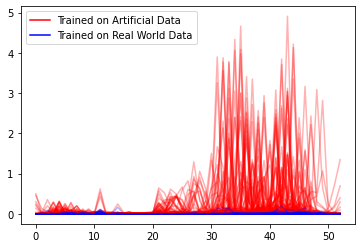

In [44]:
plotSpread(model1, model0)

In [93]:
#performance2, stddev2, model2 = getMeanError(numNeurons0, numNeurons1, numNeurons2, dropout, lr, loadRandomData, retMore = True)
print("Trained on purely random combinations of monoenergetic data\n", 
       "Loss = ", performance2, " ± " , stddev2 )

Trained on purely random combinations of monoenergetic data
 Loss =  0.0032758548823851575  ±  0.00014142099394209894


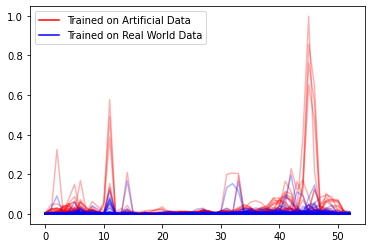

In [45]:
plotSpread(model2, model0)

In [108]:
performance3, stddev3, model3 = getMeanError(numNeurons0, numNeurons1, numNeurons2, dropout, lr, loadGaussianMonoData, retMore = True)
print("Trained on gaussian combinations of monoenergetic data\n", 
      "Loss = ", performance3, " ± " , stddev3 )

Trained on gaussian combinations of monoenergetic data
 Loss =  0.001998920976400881  ±  0.00021399746007850581


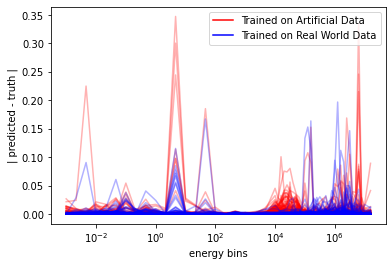

In [109]:
plotSpread(model3, model0)

In [ ]:
performance4, stddev4, model4 = getMeanError(numNeurons0, numNeurons1, numNeurons2, dropout, lr, alpha, loadRandomGaussianMonoData, retMore = True)
print("Trained on randomized gaussian combinations of monoenergetic data\n", 
      "Loss = ", performance4, " ± " , stddev4 )

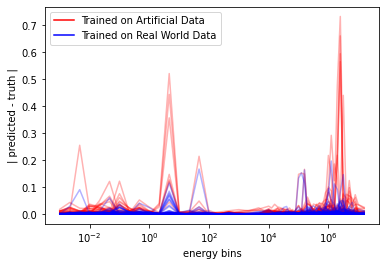

In [322]:
plotSpread(model4, model0)

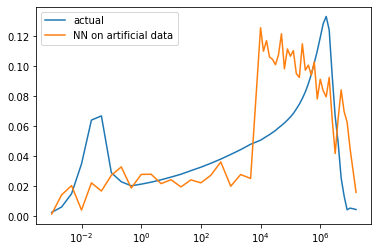

In [323]:
x, y = loadXY()

i = 5
plt.plot(Ebins, y[i], label="actual")
#plt.plot(Ebins, model0(x)[i], label="NN on real data")
plt.plot(Ebins, model4(x)[i], label="NN on artificial data")
plt.legend()
plt.xscale("log")

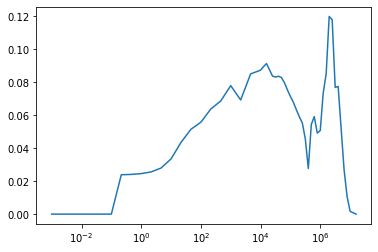

In [258]:
x,y = loadXY()
plt.plot(Ebins, y[1])
plt.xscale("log")

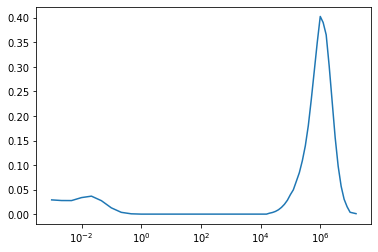

In [269]:
x,y = loadRandomGaussianMonoData()
plt.plot(Ebins, y[6])
plt.xscale("log")

Text(0.5, 0, 'energy bins')

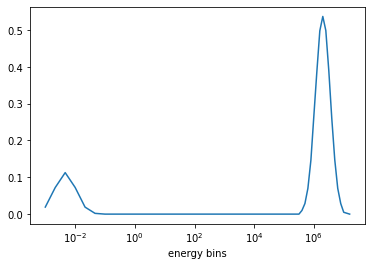

In [91]:
plt.plot(Ebins, y[150])
plt.xscale("log")
plt.xlabel("energy bins")